# Statistiques descriptives 

# Modules utiles

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
import seaborn as sns
import sklearn.preprocessing 
from sklearn.preprocessing import scale 


c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Données ENEDIS

"Ce jeu de données restitue la consommation d’électricité au pas 1/2h des points de soutirage <= 36kVA raccordés au réseau Enedis. Il donne les volumes d'énergie soutirés, les courbes de charge moyennes de clients dotés de compteurs communicants et le nombre de clients. Ces agrégats sont disponibles par plage de puissance souscrite, profil et région."

Dictionnaire des variables : https://data.enedis.fr/api/datasets/1.0/conso-inf36-region/attachments/note_externe_jdd_article_23_pdf/

In [ ]:
#chemin elena
enedis = pd.read_csv("C:/Users/elelo/Documents/ENSAE/données statapp/Données/conso-inf36-region.csv",sep=";")

#chemin jérémie
#enedis = pd.read_csv("/Users/jeremiedarracq/Stat-app/enedis.csv",sep=";")

#chemin côme
#enedis = pd.read_csv("/Users/",sep=";")


In [ ]:
enedis_2020=pd.read_csv("Données/enedis_2020.csv")
enedis_2021=pd.read_csv("Données/enedis_2021.csv")

enedis=pd.concat([enedis_2020,enedis_2021])
enedis.drop_duplicates(inplace=True)
enedis.sort_values("horodate",inplace=True)

## IMPORT BDD FINALE

In [2]:
enedis_final=pd.read_csv("Données/enedis_final.csv")

On enlève les profils pro :


In [3]:
enedis["profil_type"]=enedis["profil"].apply(lambda x : x[0:3])
enedis

NameError: name 'enedis' is not defined

In [ ]:
enedis.drop(enedis[enedis["profil_type"]!="RES"].index,inplace=True)

On récupère la date :

In [ ]:
## On extrait la date pour classifier par jour 
enedis["date"]=enedis["horodate"].apply(lambda x : x[0:10])
enedis

On ajoute la consommation moyenne par 1/2h prar profil et par plage de puissance : $\frac{total\_energie\_soutiree}{nb\_points\_soutirage}$ :

In [ ]:
enedis["energie_soutiree_moyenne"]=enedis["total_energie_soutiree_wh"]/enedis["nb_points_soutirage"]

In [134]:
enedis_final["energie_soutiree_moyenne"]=enedis_final["energie_soutiree_moyenne"]*(10**6)

## Données méteo


**Données des températures régionales du 1er janvier 2018 au 31 octobre 2022 :**

In [59]:
meteo_reg_df=pd.read_csv("Données/temperature-quotidienne-regionale.csv",";")
meteo_reg_df


c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,date,code_insee_region,region,tmin,tmax,tmoy
0,2018-01-01T00:00:00-11,2018-01-01,11,Île-de-France,5.96,9.28,7.62
1,2018-01-01T00:00:00-28,2018-01-01,28,Normandie,5.00,8.98,6.99
2,2018-01-01T00:00:00-24,2018-01-01,24,Centre-Val de Loire,5.25,9.68,7.47
3,2018-01-02T00:00:00-11,2018-01-02,11,Île-de-France,5.32,13.60,9.46
4,2018-01-02T00:00:00-84,2018-01-02,84,Auvergne-Rhône-Alpes,3.02,11.56,7.29
...,...,...,...,...,...,...,...
32404,2022-10-30T00:00:00-93,2022-10-30,93,Provence-Alpes-Côte d'Azur,11.82,23.62,17.72
32405,2022-10-30T00:00:00-32,2022-10-30,32,Hauts-de-France,11.66,16.96,14.31
32406,2022-10-30T00:00:00-76,2022-10-30,76,Occitanie,12.33,23.24,17.78
32407,2022-10-31T00:00:00-24,2022-10-31,24,Centre-Val de Loire,11.05,21.63,16.34


In [ ]:
meteo_reg_df.groupby(["region"])["tmoy"]

Boite à moustache des températures. Consommation moyenne quotidienne par région, chaque jour combien un foyer consomme

## Données socio économique

In [25]:
socio=pd.read_csv("Données/data_socio.csv",sep=";",header=2)
socio

,Code,Libellé,"Part des ""artisans, commerçants, chefs d'entreprise"" dans la population 2018","Part des ""employés"" dans la population 2018","Part des ""ouvriers"" dans la population 2018","Part des ""retraités"" dans la population 2018","Part des ""agriculteurs exploitants"" dans la population 2018","Part des ""professions intermédiaires"" dans la population 2018","Part des ""autres sans activité professionnelle"" dans la population 2018","Part des ""autres sans activité professionnelle"" dans la population 2018.1","Part des ""cadres et professions intellectuelles supérieures"" dans la population 2018",Médiane du revenu disponible par UC 2018,Population au dernier recensement 2018,Part des 15-29 ans 2018,Part des 30-44 ans 2018,Part des 45-59 ans 2018,Part des 60-74 ans 2018,Part des 75 ans et plus 2018,Taux de chômage des 15 ans et plus (RP) 2018
0,1,Guadeloupe,4.9,18.7,10.4,23.0,0.8,12.0,25.3,26.5,4.8,NaN,387629.0,16.4,16.3,23.3,17.3,8.3,28.3
1,2,Martinique,3.9,19.0,11.1,25.2,0.7,12.4,22.4,22.8,5.2,17880.0,368783.0,15.7,15.5,24.6,18.2,9.6,23.0
2,3,Guyane,3.3,15.2,10.7,7.0,0.8,10.9,46.8,51.1,5.2,NaN,276128.0,23.4,20.5,14.5,6.8,1.9,34.2
3,4,La Réunion,3.5,20.3,13.1,14.9,0.9,12.2,30.1,35.2,4.9,15440.0,855961.0,19.7,19.2,21.2,12.3,4.7,32.8
4,6,Mayotte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,11,Île-de-France,3.2,16.4,8.5,19.4,0.1,15.9,18.3,20.7,18.2,23860.0,12213447.0,20.0,21.2,19.4,13.2,6.8,12.1
6,24,Centre-Val de Loire,3.2,16.0,13.9,31.0,1.0,13.8,14.1,16.2,7.1,21560.0,2572853.0,15.9,17.5,20.1,18.1,10.7,12.5
7,27,Bourgogne-Franche-Comté,3.3,15.2,14.8,31.4,1.2,13.1,14.6,17.1,6.3,21480.0,2807807.0,16.2,17.3,20.1,18.6,10.9,12.0
8,28,Normandie,3.2,16.0,14.4,30.1,1.0,13.4,15.5,17.6,6.4,21200.0,3327477.0,16.9,17.7,19.9,17.8,9.9,13.2
9,32,Hauts-de-France,2.6,16.4,14.7,25.5,0.5,13.5,19.8,23.4,7.0,20110.0,6004108.0,18.5,18.8,19.5,15.9,7.9,16.3


In [ ]:
socio["Code"]=socio["Code"].astype("str")
socio.drop( socio[ (socio['Code'] == "1") | (socio['Code'] == "2") | (socio['Code'] == "3") | (socio['Code'] == "4") | (socio['Code'] == "6")].index, inplace=True)
socio

## Base de données merged

In [ ]:
enedis["code_region"]=enedis["code_region"].astype("str")

In [ ]:
enedis_socio=pd.merge(enedis,socio,how='left',left_on="code_region",right_on="Code")

Finalement, il faut merger les données météo et enedis sur date et région

In [ ]:
meteo_reg_df["code_insee_region"]=meteo_reg_df["code_insee_region"].astype("str")

In [ ]:
enedis_final=pd.merge(enedis_socio,meteo_reg_df,how='left',left_on=["date","code_region"],right_on=["date","code_insee_region"])

In [ ]:
enedis_final.to_csv("Données/enedis_final.csv",index=False)

## Statistiques descriptives sur bdd enedis

In [ ]:
# Affiche les données où il y a des valeurs manquantes pour tmoy

bool_series = pd.isnull(enedis_final["tmoy"])
nul=enedis_final[bool_series]
nul

# il manque 10 903 lignes de températures, pour la journée du 2021-04-30


#### Statistiques sur les températures

* Variation de la température par jour par région 
  

In [ ]:
res=enedis_final[enedis_final["region_x"]=='Occitanie'].groupby("date")["tmoy"].mean()
plt.figure(figsize=(20, 8))
plt.plot(res)
t2=["2020-06-06","2020-08-06","2020-10-06","2020-12-06","2021-02-06","2021-04-06","2021-06-06"]
plt.xticks(t2,["juin 2020","aout 2020","octobre 2020","décembre 2020","février 2021","avril 2021","juin 2021"])
plt.xlabel('date')
plt.ylabel('temperature')
plt.title("Variation de la température par jour pour l'"+'Occitanie',size=18)
plt.show()

In [ ]:
def temp_day_region(df,region):
    res=enedis_final[enedis_final["region_x"]==region].groupby("date")["tmoy"].mean()
    plt.plot(res, label= region)
    t2=["2020-06-06","2020-08-06","2020-10-06","2020-12-06","2021-02-06","2021-04-06","2021-06-06"]
    plt.xticks(t2,["juin 2020","aout 2020","octobre 2020","décembre 2020","février 2021","avril 2021","juin 2021"])
    plt.xlabel('date')
    plt.ylabel('temperature')
    plt.title("Variation de la température par jour pour "+region,size=18)
    
    

In [ ]:
plt.figure(figsize=(20, 8))
temp_day_region(enedis_final,'Centre-Val de Loire')

In [4]:
regions=list(enedis_final["region_x"].unique())

def temp_day_regions(df,regions):
    plt.figure(figsize=(20, 8))
    for region in regions:
        temp_day_region(enedis_final,region)
    t2=["2020-06-06","2020-08-06","2020-10-06","2020-12-06","2021-02-06","2021-04-06","2021-06-06"]
    plt.xticks(t2,["juin 2020","aout 2020","octobre 2020","décembre 2020","février 2021","avril 2021","juin 2021"])
    plt.xlabel('date')
    plt.ylabel('temperature')
    plt.legend()
    plt.title("Variation de la température par jour par région",size=18)
    plt.show()

temp_day_regions(enedis_final,regions)

NameError: name 'temp_day_region' is not defined

<Figure size 1440x576 with 0 Axes>

* Corrélation entre Température moyenne et énergie moyenne soutirée par jour (A verifier)

## On va créer deux df : un avec les profils hautes conso >6kva et les autres <6kva

In [9]:
haute_conso=enedis_final[enedis_final["profil"]=="RES11 (+ RES11WE)"]
basse_conso=enedis_final[enedis_final["profil"]=="RES1 (+ RES1WE)"]

In [28]:
def corr_total_energie_temperature(df,region,type_conso):
    plt.figure(figsize=(20, 8))
    plt.ylabel("total d'energie soutirée par jour")
    plt.xlabel('temperature')
    plt.legend()
    plt.title("Corrélation entre température moyenne et énergie moyenne soutirée par jour pour "+region+" "+type_conso,size=18)
    X1=df[df["region_x"]==region].groupby("date")["tmoy"].mean() # moyenne des températures par jour
    X2=df[df["region_x"]==region].groupby("date")["energie_soutiree_moyenne"].mean() # moyenne énergie soutirée par jour 
    if type_conso=="haute conso":
        plt.plot(X1,X2,"oc")
    else:
        plt.plot(X1,X2,"ob")
    plt.show()
    correlation=X1.corr(X2)
    print("La corrélation est de " +str(correlation))
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


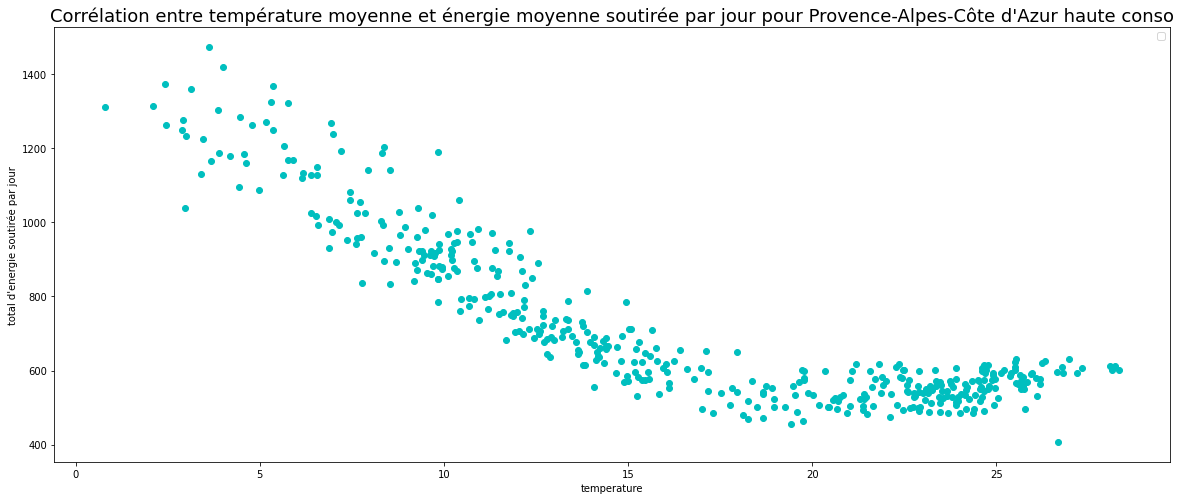

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


La corrélation est de -0.8661417324212004


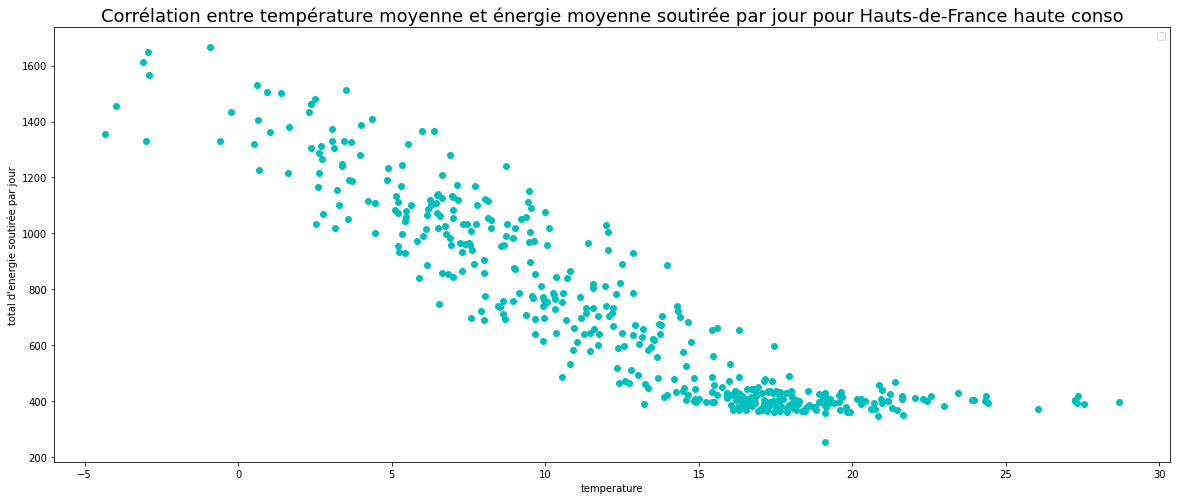

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


La corrélation est de -0.9095306707974153


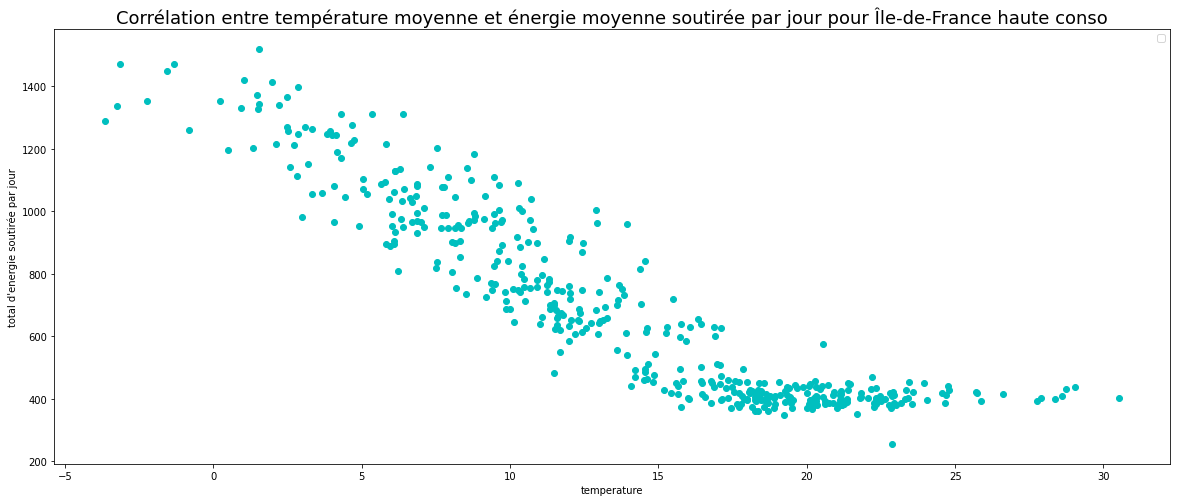

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


La corrélation est de -0.916455655755342


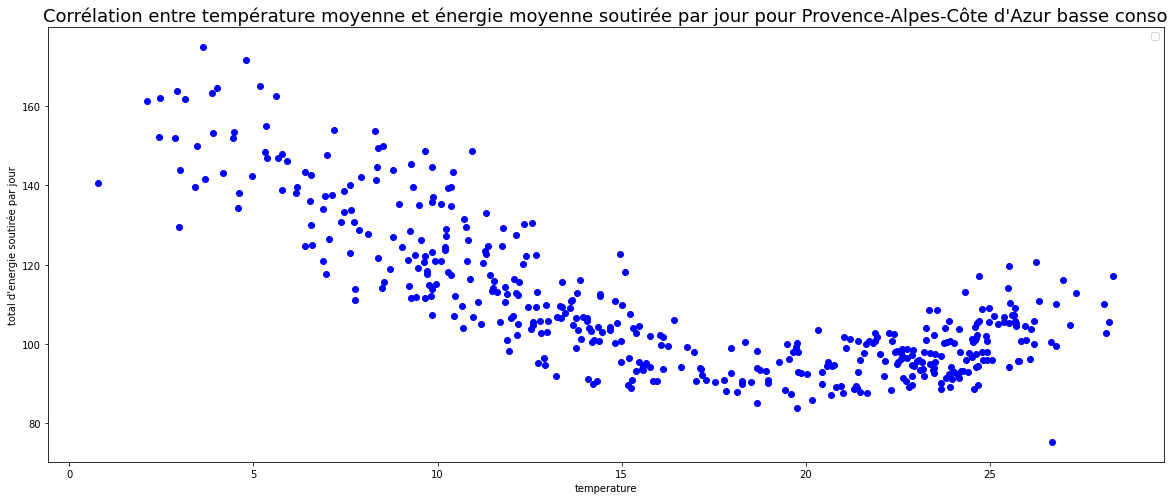

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


La corrélation est de -0.7517298630870904


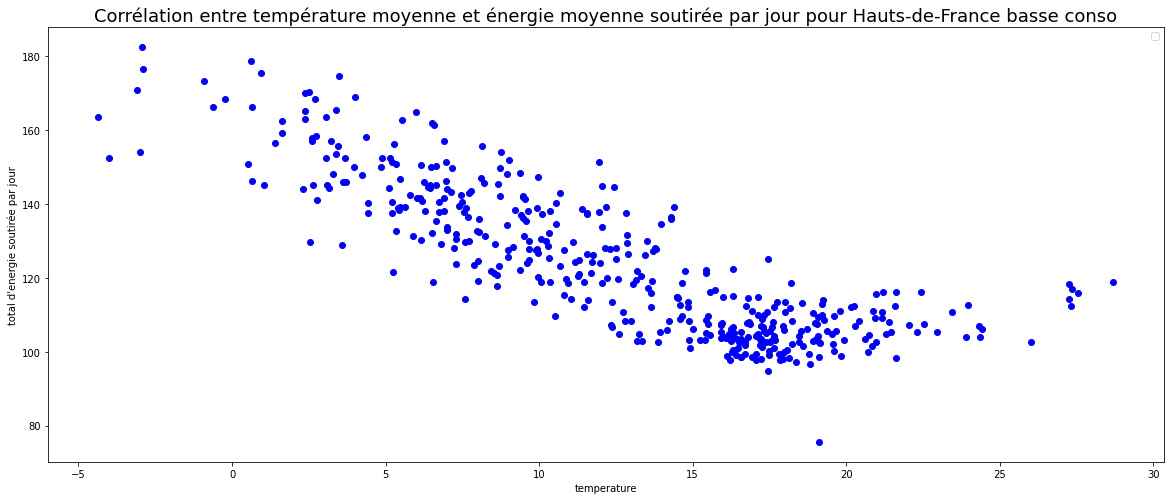

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


La corrélation est de -0.8445048032969374


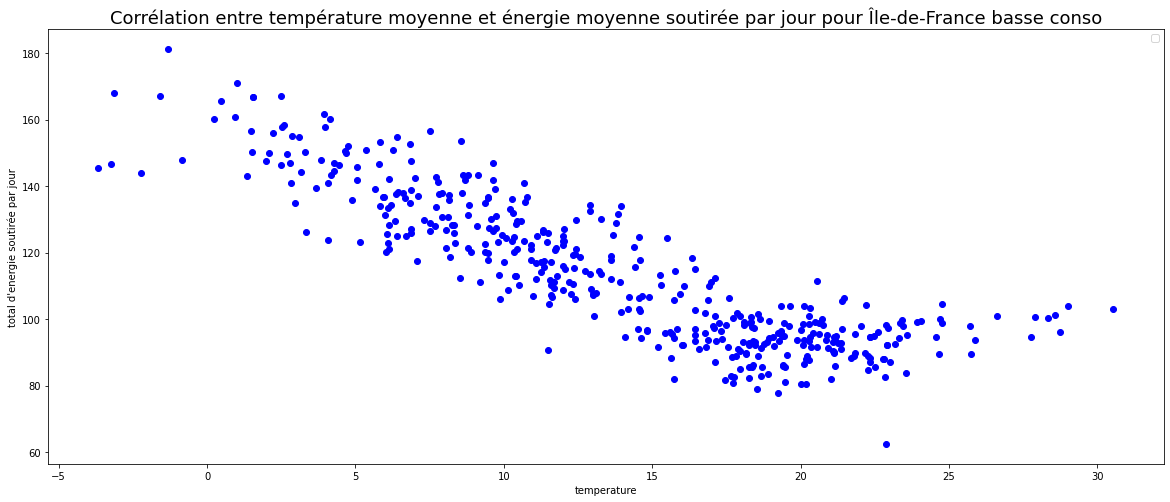

La corrélation est de -0.873392697852359


In [32]:
# Les points correspondent à un jour : donc il y a plus de 365 points
#pour PACA, plus d'énergie soutirée en été à partir de 25 degrés que pour d'autres régions (effet clim) (600kW)

corr_total_energie_temperature(haute_conso,"Provence-Alpes-Côte d'Azur","haute conso")
corr_total_energie_temperature(haute_conso,"Hauts-de-France","haute conso")
corr_total_energie_temperature(haute_conso,"Île-de-France","haute conso")


corr_total_energie_temperature(basse_conso,"Provence-Alpes-Côte d'Azur","basse conso")
corr_total_energie_temperature(basse_conso,"Hauts-de-France","basse conso")
corr_total_energie_temperature(basse_conso,"Île-de-France","basse conso")


In [37]:
def conso_day_reg(df,region,type_conso):
    res=df[df["region_x"]==region].groupby("date")["energie_soutiree_moyenne"].mean()
    plt.figure(figsize=(20, 8))
    if type_conso=="haute conso":
        plt.plot(res,"c")
    else :
        plt.plot(res,"blue")
    t2=["2020-06-06","2020-08-06","2020-10-06","2020-12-06","2021-02-06","2021-04-06","2021-06-06"]
    plt.xticks(t2,["juin 2020","aout 2020","octobre 2020","décembre 2020","février 2021","avril 2021","juin 2021"])
    plt.xlabel('date')
    plt.ylabel('consommation moyenne en Wh par jour')
    plt.title("Variation de la consommation électrique sur 1 an pour l'"+region+" profil "+type_conso,size=18)
    plt.show
    

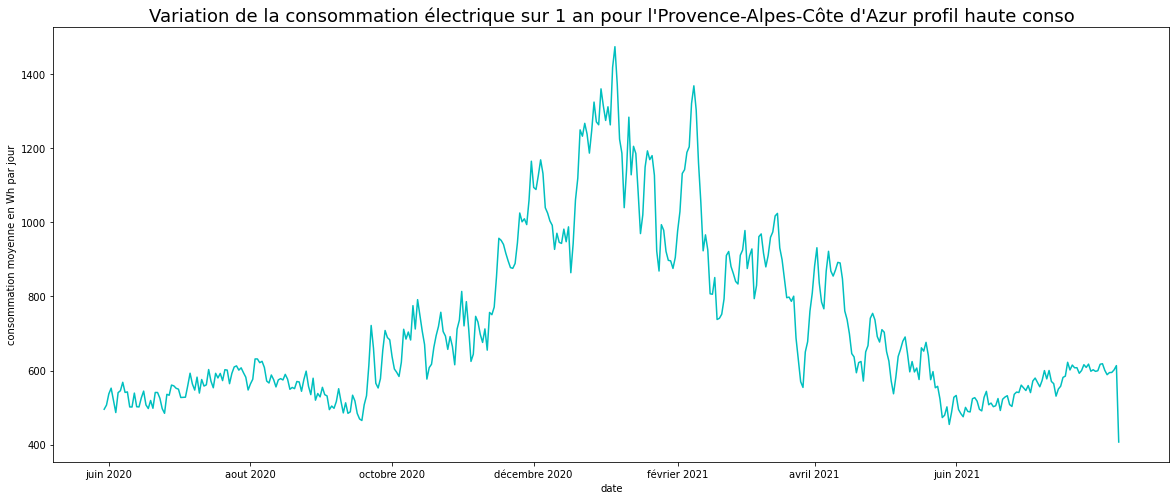

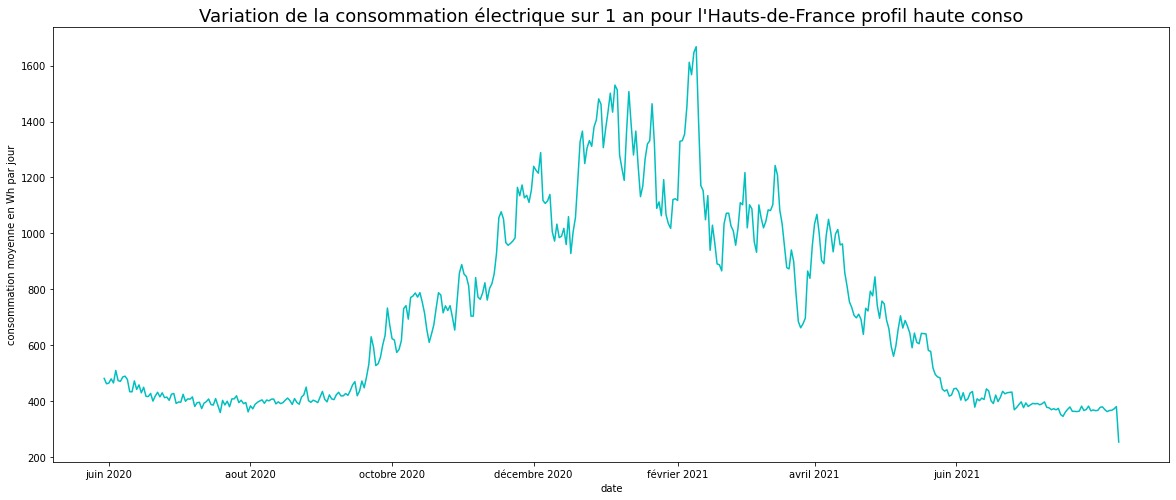

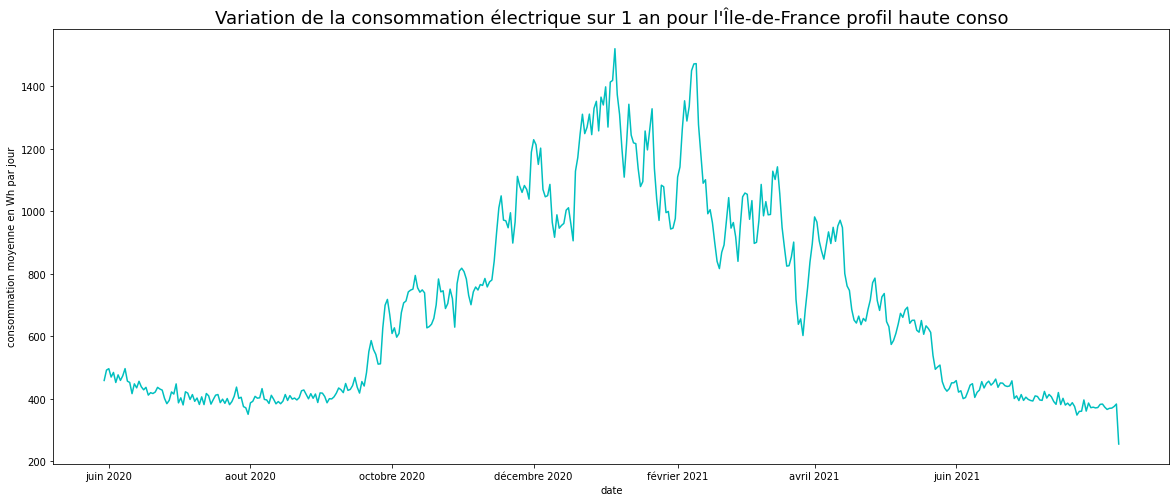

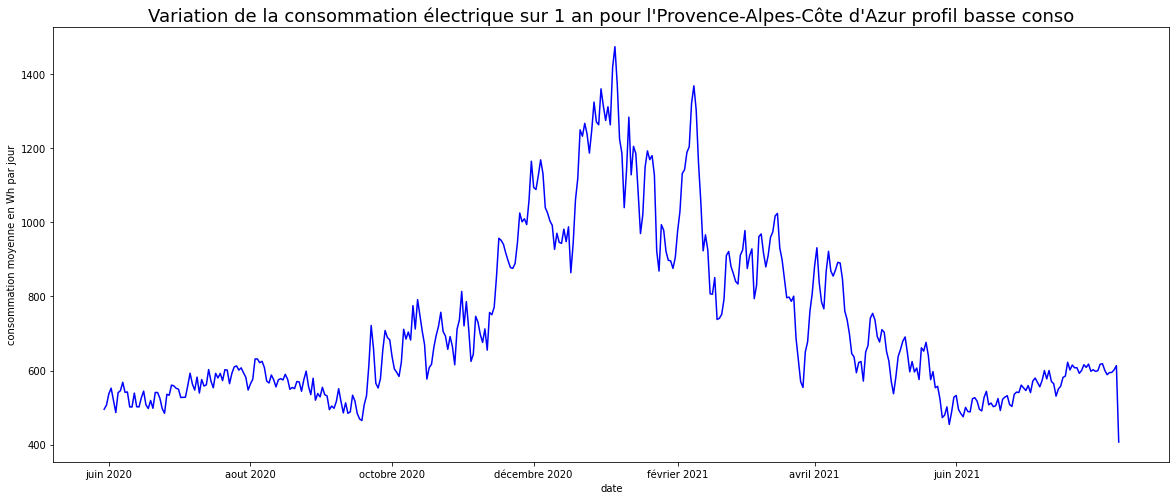

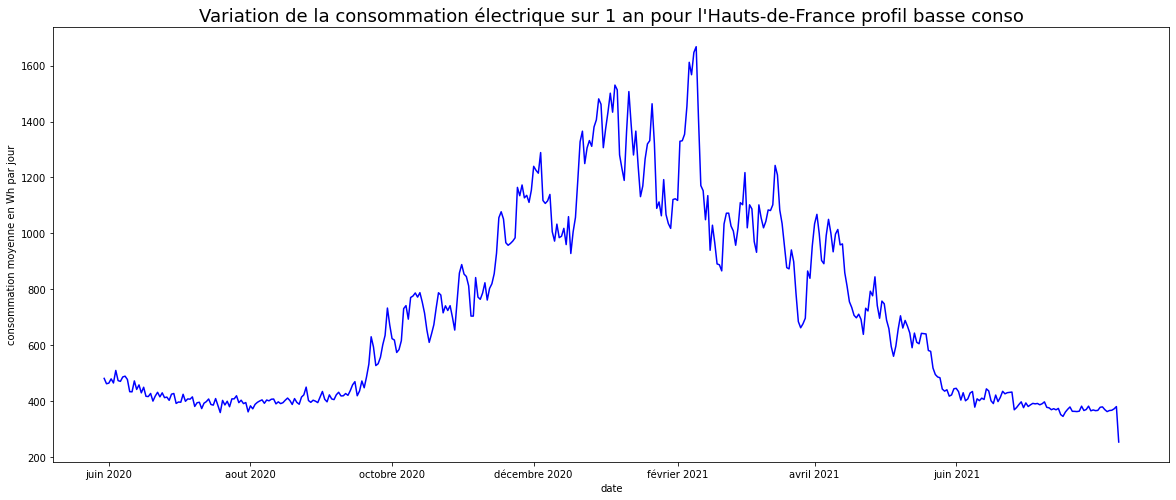

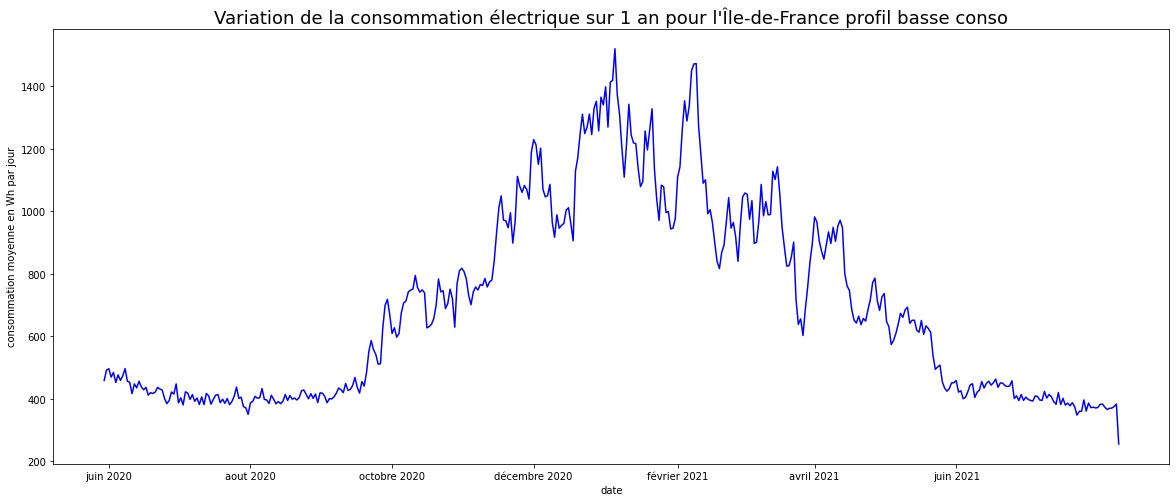

In [40]:
conso_day_reg(haute_conso,"Provence-Alpes-Côte d'Azur","haute conso")
conso_day_reg(haute_conso,'Hauts-de-France',"haute conso")
conso_day_reg(haute_conso,'Île-de-France',"haute conso")

conso_day_reg(haute_conso,"Provence-Alpes-Côte d'Azur","basse conso")
conso_day_reg(haute_conso,'Hauts-de-France',"basse conso")
conso_day_reg(haute_conso,'Île-de-France',"basse conso")

<AxesSubplot:title={'center':'energie_soutiree_moyenne'}, xlabel='region_x'>

<Figure size 2160x720 with 0 Axes>

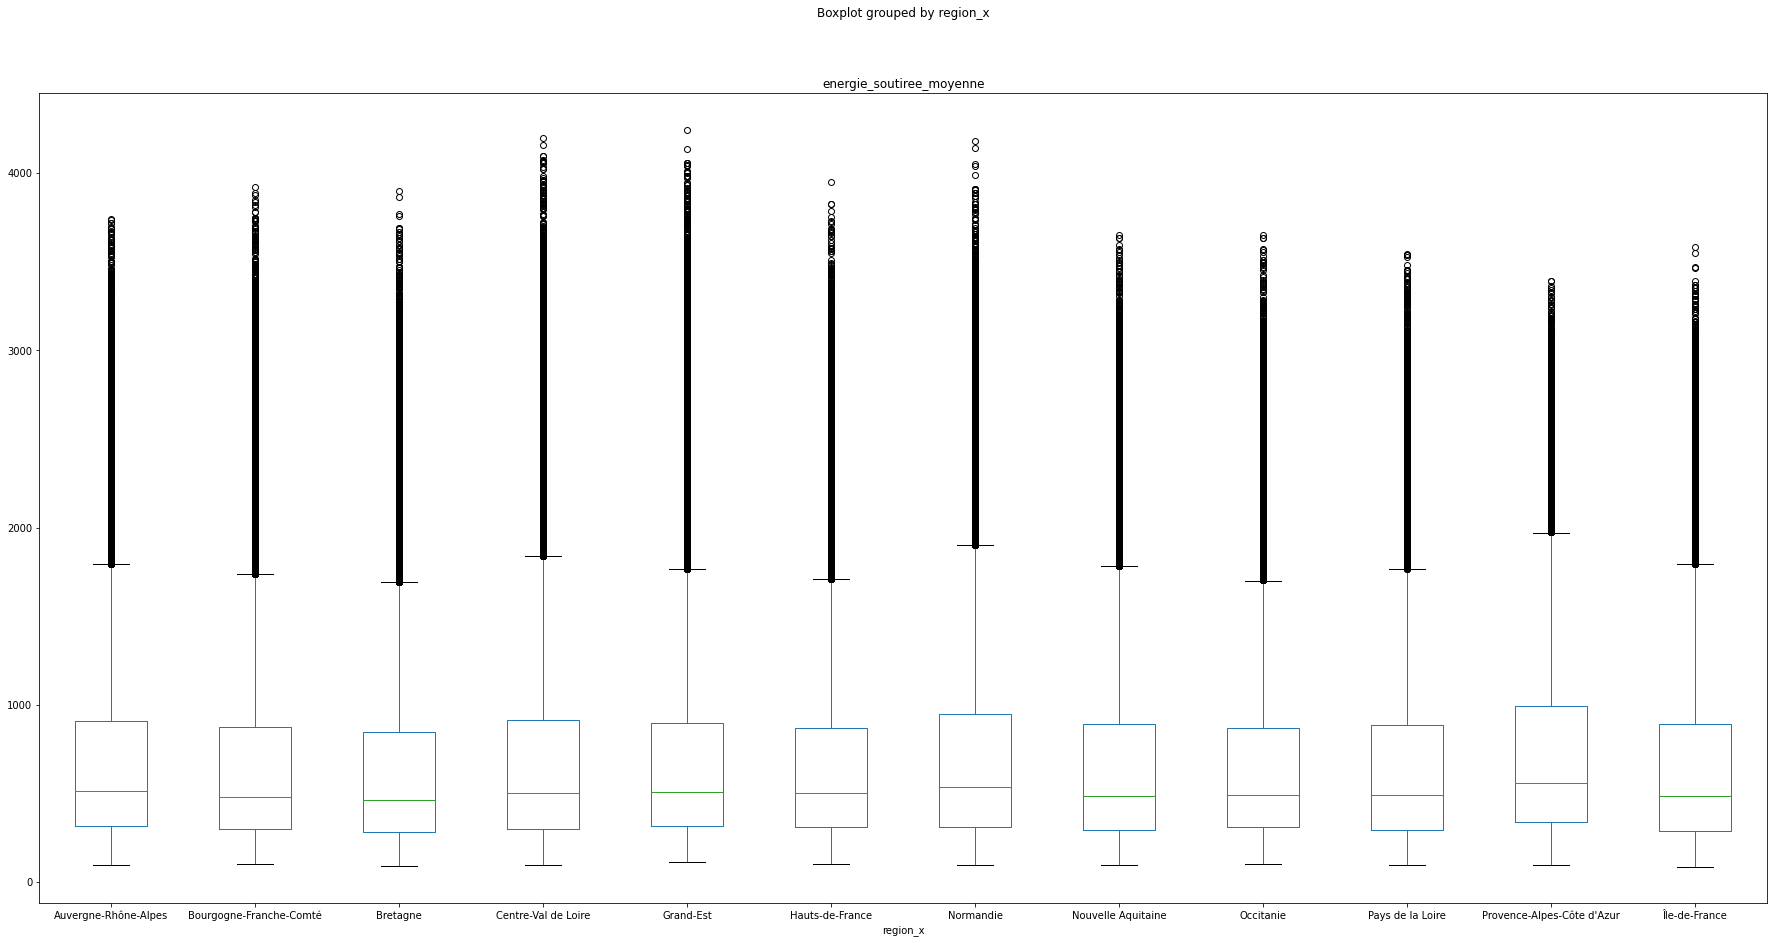

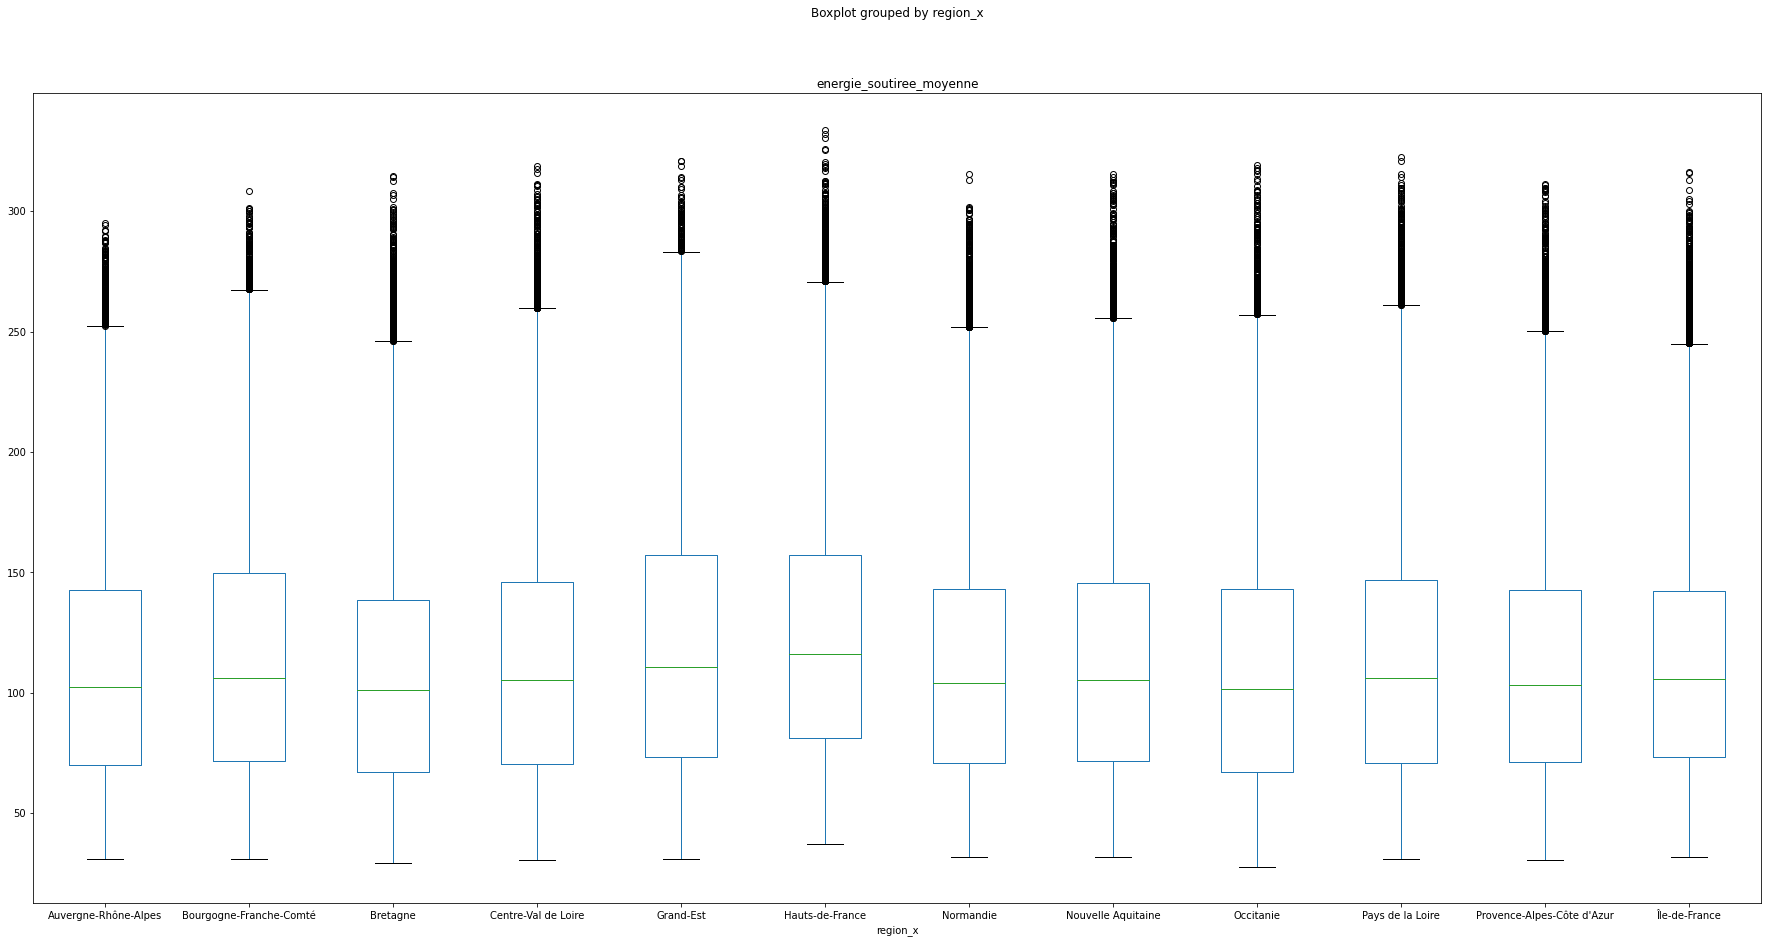

In [19]:
plt.figure(figsize=(30, 10))
haute_conso.boxplot(by="region_x",column=["energie_soutiree_moyenne"],grid=False,figsize=(30, 15))
basse_conso.boxplot(by="region_x",column=["energie_soutiree_moyenne"],grid=False,figsize=(30, 15))

### Deux barplot : conso totale et population

<function matplotlib.pyplot.show(close=None, block=None)>

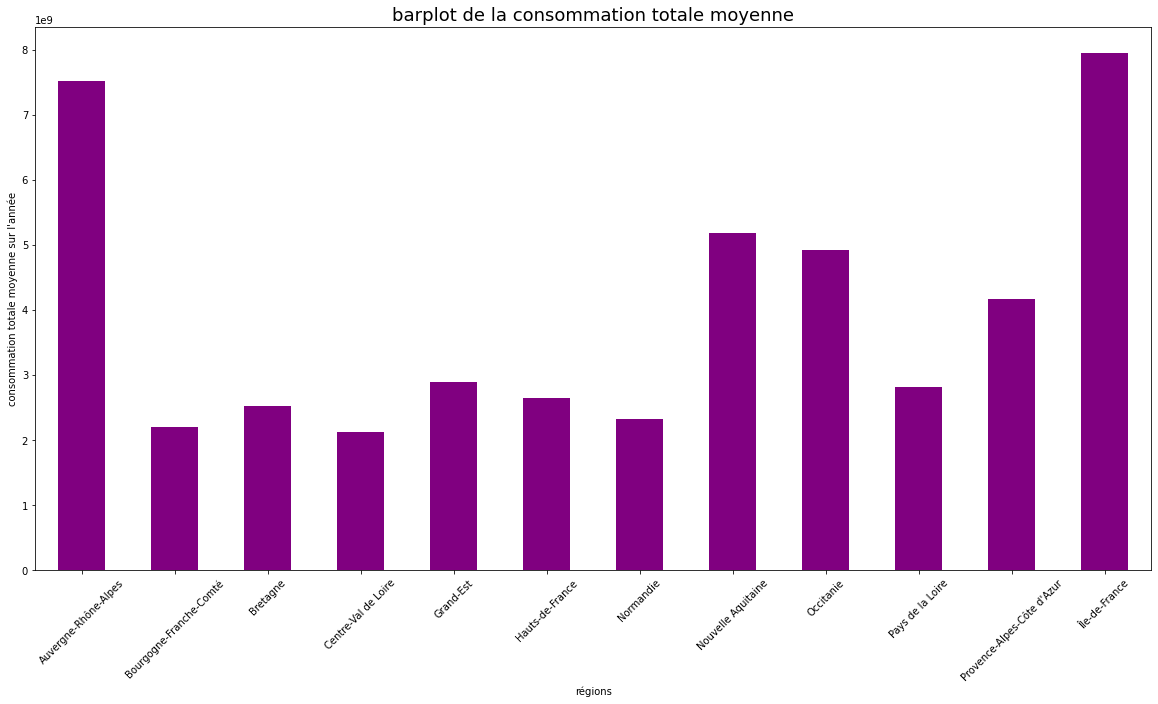

In [50]:
# Premièrement : conso totale pour chaque jour par région
# deuxièment : moyenne des conso totale sur l'année
# barplot des conso totale sur l'année


total_energie_temp=haute_conso.groupby(["region_x","date"])["total_energie_soutiree_wh"].sum().reset_index()
total_energie=total_energie_temp.groupby("region_x")["total_energie_soutiree_wh"].mean()

plt.figure(figsize=(20, 10))
total_energie.plot.bar(color="purple")
plt.xlabel('régions')
plt.xticks(rotation = 45)
plt.ylabel("consommation totale moyenne sur l'année")
plt.title("barplot de la consommation totale moyenne",size=18)
plt.show



<function matplotlib.pyplot.show(close=None, block=None)>

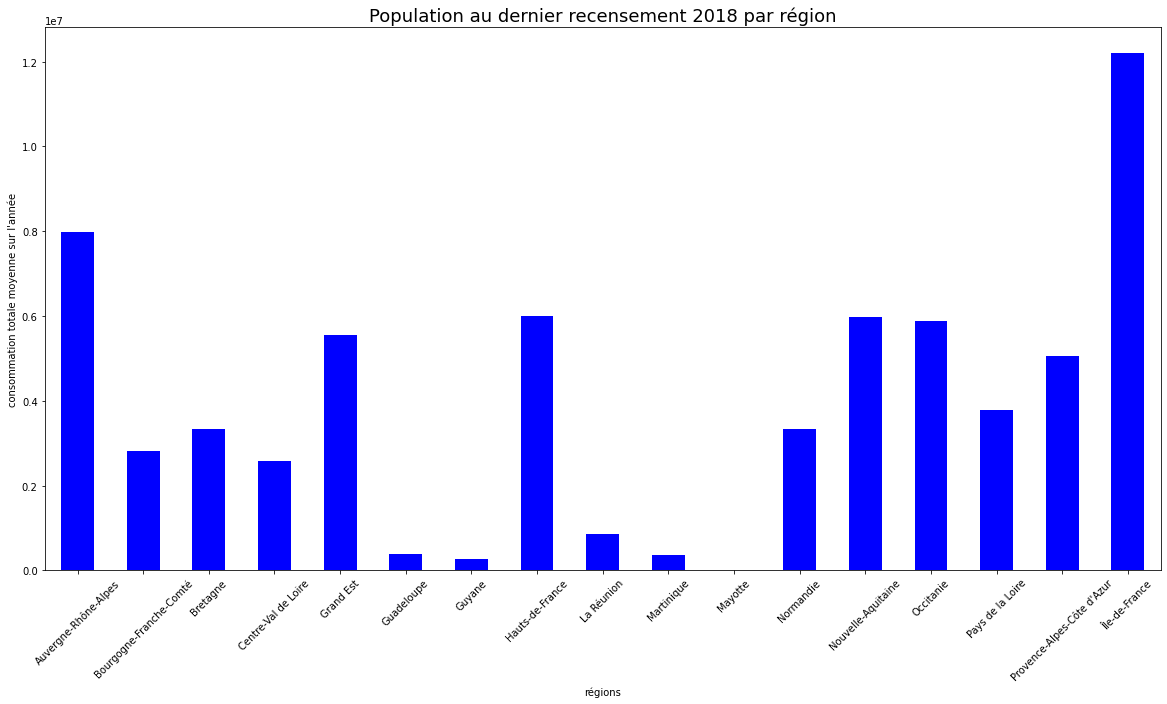

In [41]:
population=socio.drop(socio[(socio["Libellé"]=="Corse")].index)
population=population.groupby("Libellé")["Population au dernier recensement 2018"].mean()
plt.figure(figsize=(20, 10))
population.plot.bar(color="blue")
plt.xlabel('régions')
plt.xticks(rotation = 45)
plt.ylabel("consommation totale moyenne sur l'année")
plt.title("Population au dernier recensement 2018 par région",size=18)
plt.show

# Par saison : graphique des molaires 

### Données pour haute conso :

In [10]:
haute_conso["mois"]=haute_conso["date"].apply(lambda x : x[5:7])

C:\Users\elelo\AppData\Local\Temp/ipykernel_21304/1512636546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  haute_conso["mois"]=haute_conso["date"].apply(lambda x : x[5:7])


In [11]:
ete=haute_conso[(haute_conso["mois"]=="06")|(haute_conso["mois"]=="07")|(haute_conso["mois"]=="08")]

automne=haute_conso[(haute_conso["mois"]=="09")|(haute_conso["mois"]=="10")|(haute_conso["mois"]=="11")]

hiver=haute_conso[(haute_conso["mois"]=="12")|(haute_conso["mois"]=="01")|(haute_conso["mois"]=="02")]

printemps=haute_conso[(haute_conso["mois"]=="03")|(haute_conso["mois"]=="04")|(haute_conso["mois"]=="05")]

### Données pour basse conso :

In [12]:
basse_conso["mois"]=basse_conso["date"].apply(lambda x : x[5:7])

C:\Users\elelo\AppData\Local\Temp/ipykernel_21304/3728763804.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basse_conso["mois"]=basse_conso["date"].apply(lambda x : x[5:7])


In [13]:
ete_basse=basse_conso[(basse_conso["mois"]=="06")|(basse_conso["mois"]=="07")|(basse_conso["mois"]=="08")]

automne_basse=basse_conso[(basse_conso["mois"]=="09")|(basse_conso["mois"]=="10")|(basse_conso["mois"]=="11")]

hiver_basse=basse_conso[(basse_conso["mois"]=="12")|(basse_conso["mois"]=="01")|(basse_conso["mois"]=="02")]

printemps_basse=basse_conso[(basse_conso["mois"]=="03")|(basse_conso["mois"]=="04")|(basse_conso["mois"]=="05")]

### Données pour les quantiles :


In [93]:
haute_conso.total_energie_soutiree_wh.describe()
# Premier quantile de conso = 1.269489e+06
# Troisième quantile de conso = 2.349043e+07 


count    1.037800e+06
mean     1.994778e+07
std      3.508418e+07
min      6.020000e+04
25%      1.269489e+06
50%      4.325990e+06
75%      2.349043e+07
max      3.941065e+08
Name: total_energie_soutiree_wh, dtype: float64

In [15]:
haute_conso_Q1=haute_conso[haute_conso.total_energie_soutiree_wh<=1.269489e+06]
haute_conso_Q3=haute_conso[haute_conso.total_energie_soutiree_wh<=2.349043e+07]

In [16]:

ete_Q1=haute_conso_Q1[(haute_conso_Q1["mois"]=="06")|(haute_conso_Q1["mois"]=="07")|(haute_conso_Q1["mois"]=="08")]

automne_Q1=haute_conso_Q1[(haute_conso_Q1["mois"]=="09")|(haute_conso_Q1["mois"]=="10")|(haute_conso_Q1["mois"]=="11")]

hiver_Q1=haute_conso_Q1[(haute_conso_Q1["mois"]=="12")|(haute_conso_Q1["mois"]=="01")|(haute_conso_Q1["mois"]=="02")]

printemps_Q1=haute_conso_Q1[(haute_conso_Q1["mois"]=="03")|(haute_conso_Q1["mois"]=="04")|(haute_conso_Q1["mois"]=="05")]


In [17]:

ete_Q3=haute_conso_Q3[(haute_conso_Q3["mois"]=="06")|(haute_conso_Q3["mois"]=="07")|(haute_conso_Q3["mois"]=="08")]

automne_Q3=haute_conso_Q3[(haute_conso_Q3["mois"]=="09")|(haute_conso_Q3["mois"]=="10")|(haute_conso_Q3["mois"]=="11")]

hiver_Q3=haute_conso_Q3[(haute_conso_Q3["mois"]=="12")|(haute_conso_Q3["mois"]=="01")|(haute_conso_Q3["mois"]=="02")]

printemps_Q3=haute_conso_Q3[(haute_conso_Q3["mois"]=="03")|(haute_conso_Q3["mois"]=="04")|(haute_conso_Q3["mois"]=="05")]

## Fonction pour tracer les molaires :

In [18]:
haute=[ete,automne,hiver,printemps]

In [25]:
# molaire conso moyenne par heure pour chaque jour de la saison
def molaire_saison(data_saison,region,saison,color):
    conso_saison_region=data_saison[data_saison["region_x"]==region]

    conso_saison_region["heure"]=conso_saison_region["horodate"].apply(lambda x : x[11:16])
    total_conso_saison_region=conso_saison_region.groupby("heure")["energie_soutiree_moyenne"].mean()

    axes = plt.gca()
    axes.set_xlim("00:00","00:00")
    plt.plot(total_conso_saison_region,color,label=saison)
    t2=["00:00","04:00","08:00","12:00","15:00","18:00","21:00","23:30"]
    plt.xticks(t2,["00:00","04:00","8:00","12:00","15:00","18:00","21:00","23:30"])
    plt.xlabel('Heure')
    plt.ylabel("Consommation d'énergie")
    plt.title('Molaire pour la saison '+saison+", région "+region,size=25)


haute=[ete,automne,hiver,printemps]
basse=[ete_basse,automne_basse,hiver_basse,printemps_basse]

def molaire_toute_saison(region,type_conso):
    plt.figure(figsize=(20, 8))
    axes = plt.gca()
    axes.set_xlim("00:00","00:00")
    
    if type_conso=="basse conso":
        molaire_saison(ete_basse,region,"été","red")
        molaire_saison(automne_basse,region,"automne","brown")
        molaire_saison(hiver_basse,region,"hiver","c")
        molaire_saison(printemps_basse,region,"printemps","green")

    elif type_conso=="haute conso":
        molaire_saison(ete,region,"été","pink")
        molaire_saison(automne,region,"automne","brown")
        molaire_saison(hiver,region,"hiver","c")
        molaire_saison(printemps,region,"printemps","green")

    elif type_conso=="haute conso Q1 Q3":
        molaire_saison(ete_Q1,region,"été_Q1","orangered")
        molaire_saison(automne_Q1,region,"automne_Q1","peru")
        molaire_saison(hiver_Q1,region,"hiver_Q1","royalblue")
        molaire_saison(printemps_Q1,region,"printemps_Q1","yellowgreen")

        molaire_saison(ete_Q3,region,"été_Q3","red")
        molaire_saison(automne_Q3,region,"automne_Q3","brown")
        molaire_saison(hiver_Q3,region,"hiver_Q3","c")
        molaire_saison(printemps_Q3,region,"printemps_Q3","green")
    
    else :
        molaire_saison(ete_Q3,region,"été","red")
        molaire_saison(automne_Q3,region,"automne","brown")
        molaire_saison(hiver_Q3,region,"hiver","c")
        molaire_saison(printemps_Q3,region,"printemps","green")
    

    t2=["00:00","04:00","08:00","12:00","15:00","18:00","21:00","23:30"]
    plt.xticks(t2,["00:00","04:00","8:00","12:00","15:00","18:00","21:00","23:30"])
    plt.xlabel('Heure')
    plt.ylabel("Consommation d'énergie")
    plt.legend()
    plt.title('Molaire par saison pour la région '+region+" pour "+type_conso,size=25)
   
    plt.show()
   

C:\Users\elelo\AppData\Local\Temp/ipykernel_2160/696308862.py:24: UserWarning: Attempting to set identical left == right == [0.] results in singular transformations; automatically expanding.
  axes.set_xlim("00:00","00:00")
C:\Users\elelo\AppData\Local\Temp/ipykernel_2160/696308862.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_saison_region["heure"]=conso_saison_region["horodate"].apply(lambda x : x[11:16])
C:\Users\elelo\AppData\Local\Temp/ipykernel_2160/696308862.py:9: UserWarning: Attempting to set identical left == right == [0.] results in singular transformations; automatically expanding.
  axes.set_xlim("00:00","00:00")
C:\Users\elelo\AppData\Local\Temp/ipykernel_2160/696308862.py:5: SettingWithCopyWarning: 
A value is trying to

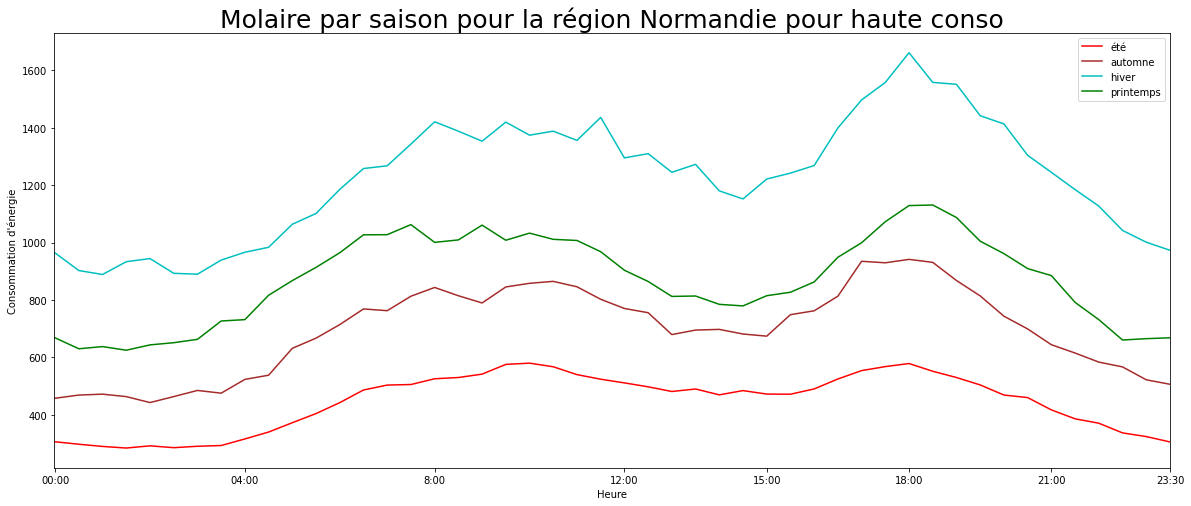

In [75]:
molaire_toute_saison("Normandie","haute conso")

C:\Users\elelo\AppData\Local\Temp/ipykernel_2160/696308862.py:24: UserWarning: Attempting to set identical left == right == [0.] results in singular transformations; automatically expanding.
  axes.set_xlim("00:00","00:00")
C:\Users\elelo\AppData\Local\Temp/ipykernel_2160/696308862.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_saison_region["heure"]=conso_saison_region["horodate"].apply(lambda x : x[11:16])
C:\Users\elelo\AppData\Local\Temp/ipykernel_2160/696308862.py:9: UserWarning: Attempting to set identical left == right == [0.] results in singular transformations; automatically expanding.
  axes.set_xlim("00:00","00:00")
C:\Users\elelo\AppData\Local\Temp/ipykernel_2160/696308862.py:5: SettingWithCopyWarning: 
A value is trying to

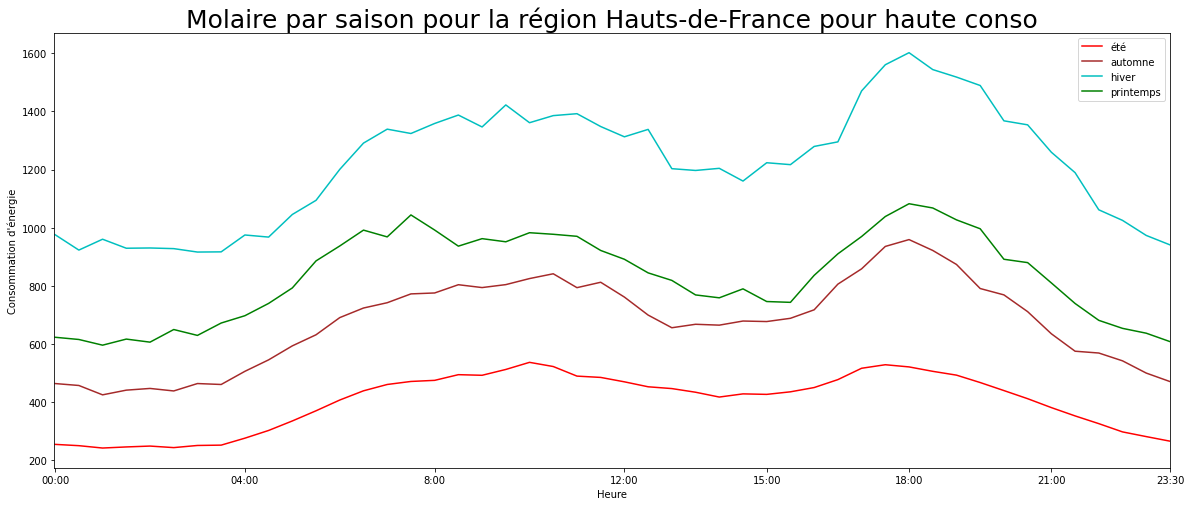

In [79]:
molaire_toute_saison("Hauts-de-France","haute conso")

C:\Users\elelo\AppData\Local\Temp/ipykernel_2160/696308862.py:24: UserWarning: Attempting to set identical left == right == [0.] results in singular transformations; automatically expanding.
  axes.set_xlim("00:00","00:00")
C:\Users\elelo\AppData\Local\Temp/ipykernel_2160/696308862.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_saison_region["heure"]=conso_saison_region["horodate"].apply(lambda x : x[11:16])
C:\Users\elelo\AppData\Local\Temp/ipykernel_2160/696308862.py:9: UserWarning: Attempting to set identical left == right == [0.] results in singular transformations; automatically expanding.
  axes.set_xlim("00:00","00:00")
C:\Users\elelo\AppData\Local\Temp/ipykernel_2160/696308862.py:5: SettingWithCopyWarning: 
A value is trying to

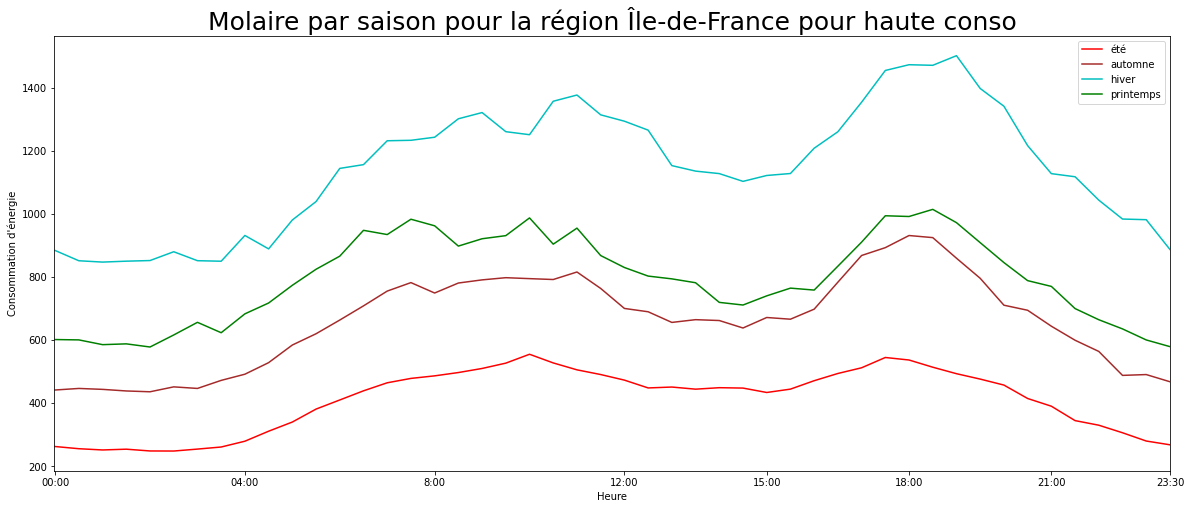

In [80]:
molaire_toute_saison("Île-de-France","haute conso")

C:\Users\elelo\AppData\Local\Temp/ipykernel_2160/696308862.py:24: UserWarning: Attempting to set identical left == right == [0.] results in singular transformations; automatically expanding.
  axes.set_xlim("00:00","00:00")
C:\Users\elelo\AppData\Local\Temp/ipykernel_2160/696308862.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_saison_region["heure"]=conso_saison_region["horodate"].apply(lambda x : x[11:16])
C:\Users\elelo\AppData\Local\Temp/ipykernel_2160/696308862.py:9: UserWarning: Attempting to set identical left == right == [0.] results in singular transformations; automatically expanding.
  axes.set_xlim("00:00","00:00")
C:\Users\elelo\AppData\Local\Temp/ipykernel_2160/696308862.py:5: SettingWithCopyWarning: 
A value is trying to

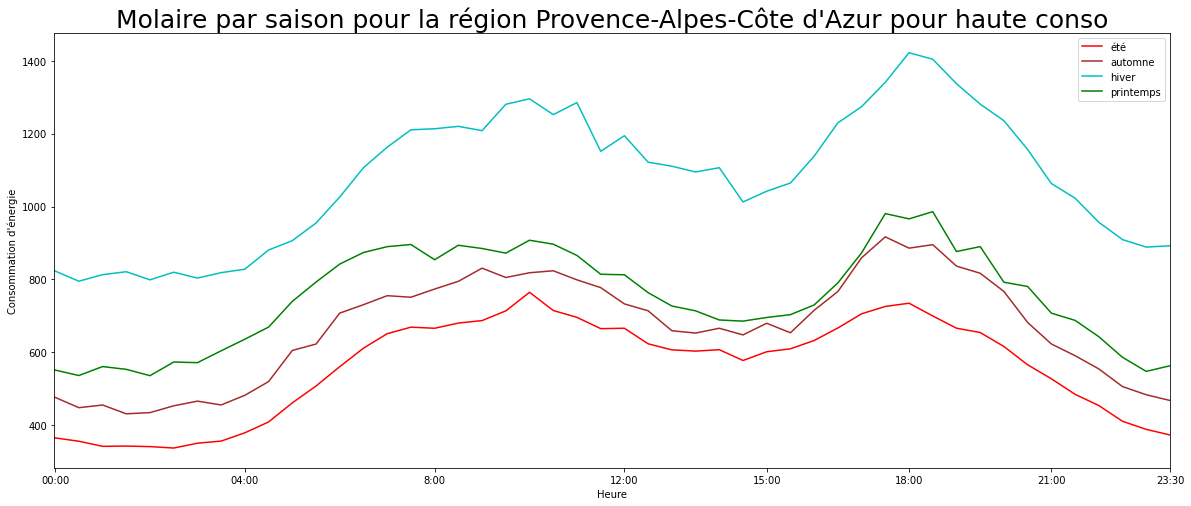

In [81]:
molaire_toute_saison("Provence-Alpes-Côte d'Azur","haute conso")

### Molaires par quantile :

C:\Users\elelo\AppData\Local\Temp/ipykernel_21304/4005405908.py:24: UserWarning: Attempting to set identical left == right == [0.] results in singular transformations; automatically expanding.
  axes.set_xlim("00:00","00:00")
C:\Users\elelo\AppData\Local\Temp/ipykernel_21304/4005405908.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_saison_region["heure"]=conso_saison_region["horodate"].apply(lambda x : x[11:16])
C:\Users\elelo\AppData\Local\Temp/ipykernel_21304/4005405908.py:9: UserWarning: Attempting to set identical left == right == [0.] results in singular transformations; automatically expanding.
  axes.set_xlim("00:00","00:00")
C:\Users\elelo\AppData\Local\Temp/ipykernel_21304/4005405908.py:5: SettingWithCopyWarning: 
A value is t

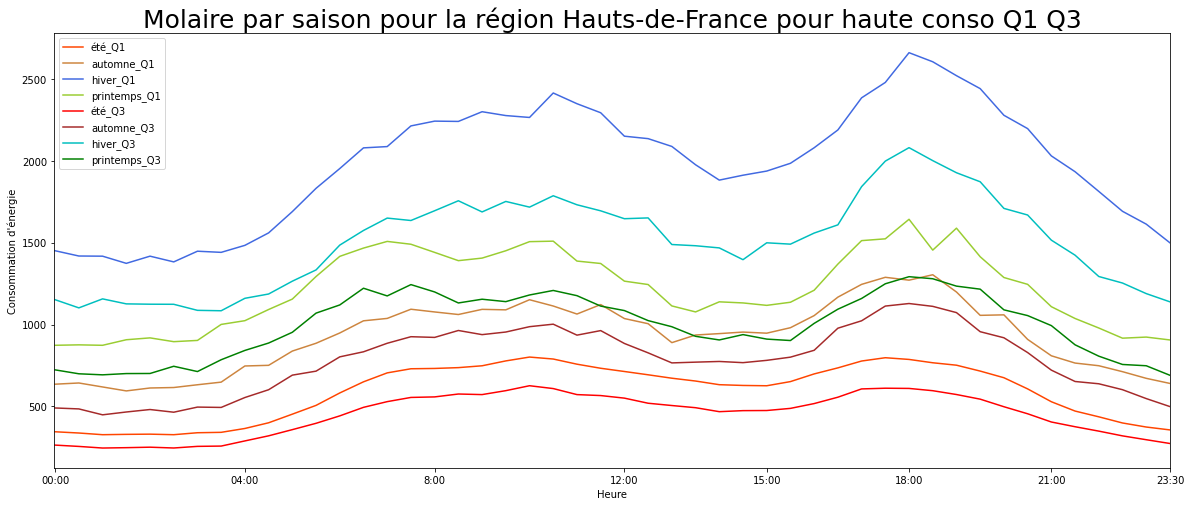

In [33]:
molaire_toute_saison("Hauts-de-France","haute conso Q1 Q3")

C:\Users\elelo\AppData\Local\Temp/ipykernel_21304/4005405908.py:24: UserWarning: Attempting to set identical left == right == [0.] results in singular transformations; automatically expanding.
  axes.set_xlim("00:00","00:00")
C:\Users\elelo\AppData\Local\Temp/ipykernel_21304/4005405908.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_saison_region["heure"]=conso_saison_region["horodate"].apply(lambda x : x[11:16])
C:\Users\elelo\AppData\Local\Temp/ipykernel_21304/4005405908.py:9: UserWarning: Attempting to set identical left == right == [0.] results in singular transformations; automatically expanding.
  axes.set_xlim("00:00","00:00")
C:\Users\elelo\AppData\Local\Temp/ipykernel_21304/4005405908.py:5: SettingWithCopyWarning: 
A value is t

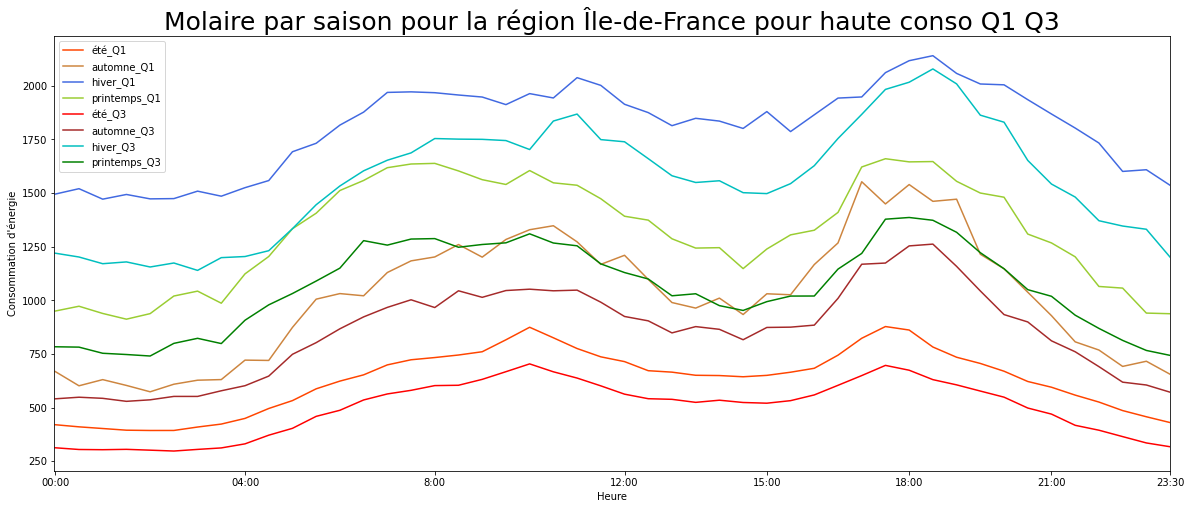

In [32]:
molaire_toute_saison("Île-de-France","haute conso Q1 Q3")

C:\Users\elelo\AppData\Local\Temp/ipykernel_21304/4005405908.py:24: UserWarning: Attempting to set identical left == right == [0.] results in singular transformations; automatically expanding.
  axes.set_xlim("00:00","00:00")
C:\Users\elelo\AppData\Local\Temp/ipykernel_21304/4005405908.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_saison_region["heure"]=conso_saison_region["horodate"].apply(lambda x : x[11:16])
C:\Users\elelo\AppData\Local\Temp/ipykernel_21304/4005405908.py:9: UserWarning: Attempting to set identical left == right == [0.] results in singular transformations; automatically expanding.
  axes.set_xlim("00:00","00:00")
C:\Users\elelo\AppData\Local\Temp/ipykernel_21304/4005405908.py:5: SettingWithCopyWarning: 
A value is t

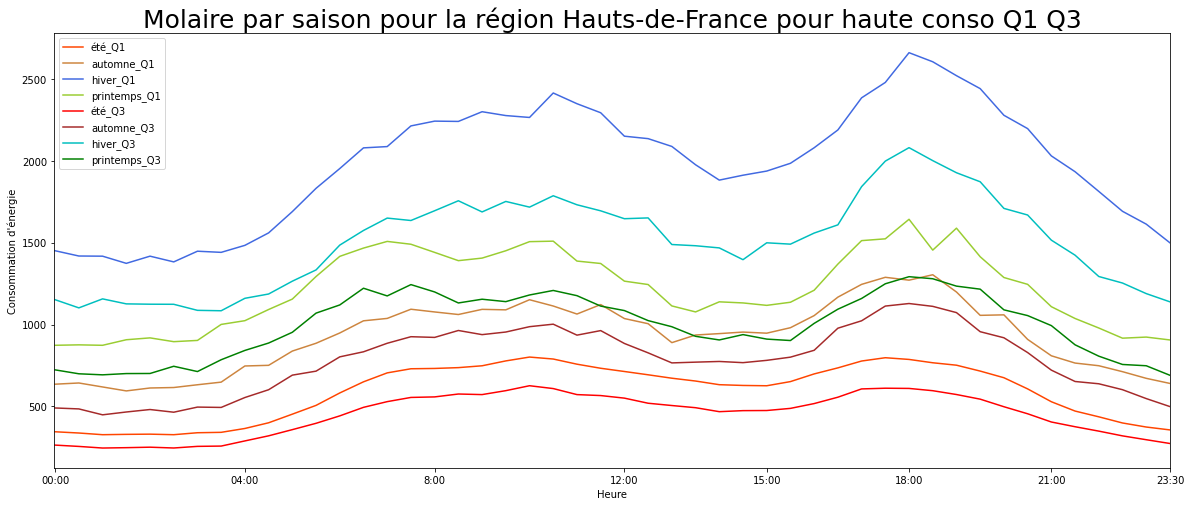

C:\Users\elelo\AppData\Local\Temp/ipykernel_21304/4005405908.py:24: UserWarning: Attempting to set identical left == right == [0.] results in singular transformations; automatically expanding.
  axes.set_xlim("00:00","00:00")
C:\Users\elelo\AppData\Local\Temp/ipykernel_21304/4005405908.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_saison_region["heure"]=conso_saison_region["horodate"].apply(lambda x : x[11:16])
C:\Users\elelo\AppData\Local\Temp/ipykernel_21304/4005405908.py:9: UserWarning: Attempting to set identical left == right == [0.] results in singular transformations; automatically expanding.
  axes.set_xlim("00:00","00:00")
C:\Users\elelo\AppData\Local\Temp/ipykernel_21304/4005405908.py:5: SettingWithCopyWarning: 
A value is t

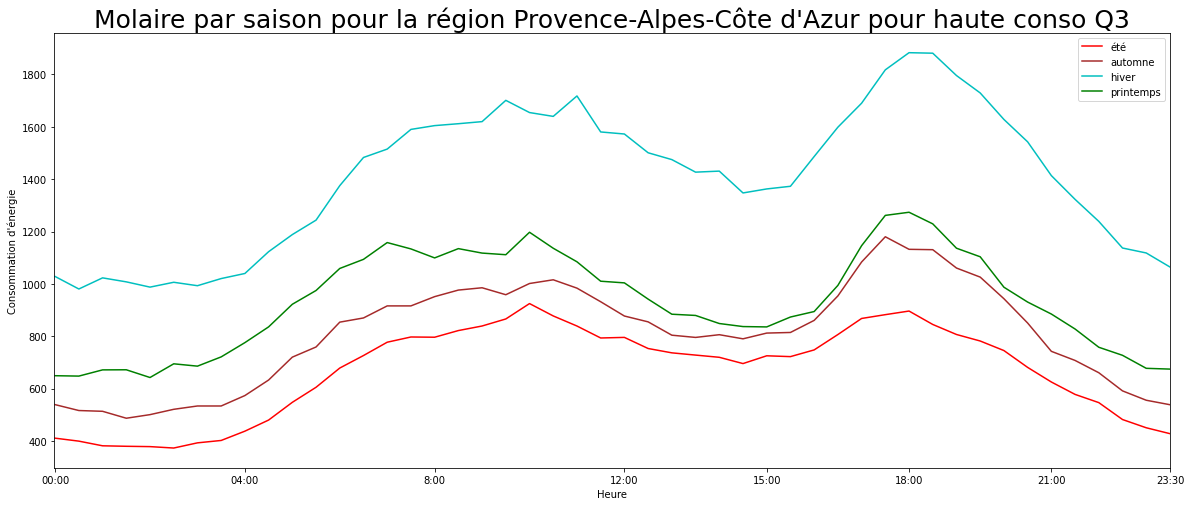

In [31]:
molaire_toute_saison("Provence-Alpes-Côte d'Azur","haute conso Q1 Q3")
molaire_toute_saison("Provence-Alpes-Côte d'Azur","haute conso Q3")

### Molaire pour une journée  pour une région

C:\Users\elelo\AppData\Local\Temp/ipykernel_2160/1253573535.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  haute_conso_30_09_2020["heure"]=haute_conso_30_09_2020["horodate"].apply(lambda x : x[11:16])
C:\Users\elelo\AppData\Local\Temp/ipykernel_2160/1253573535.py:8: UserWarning: Attempting to set identical left == right == [0.] results in singular transformations; automatically expanding.
  axes.set_xlim("00:00","00:00")


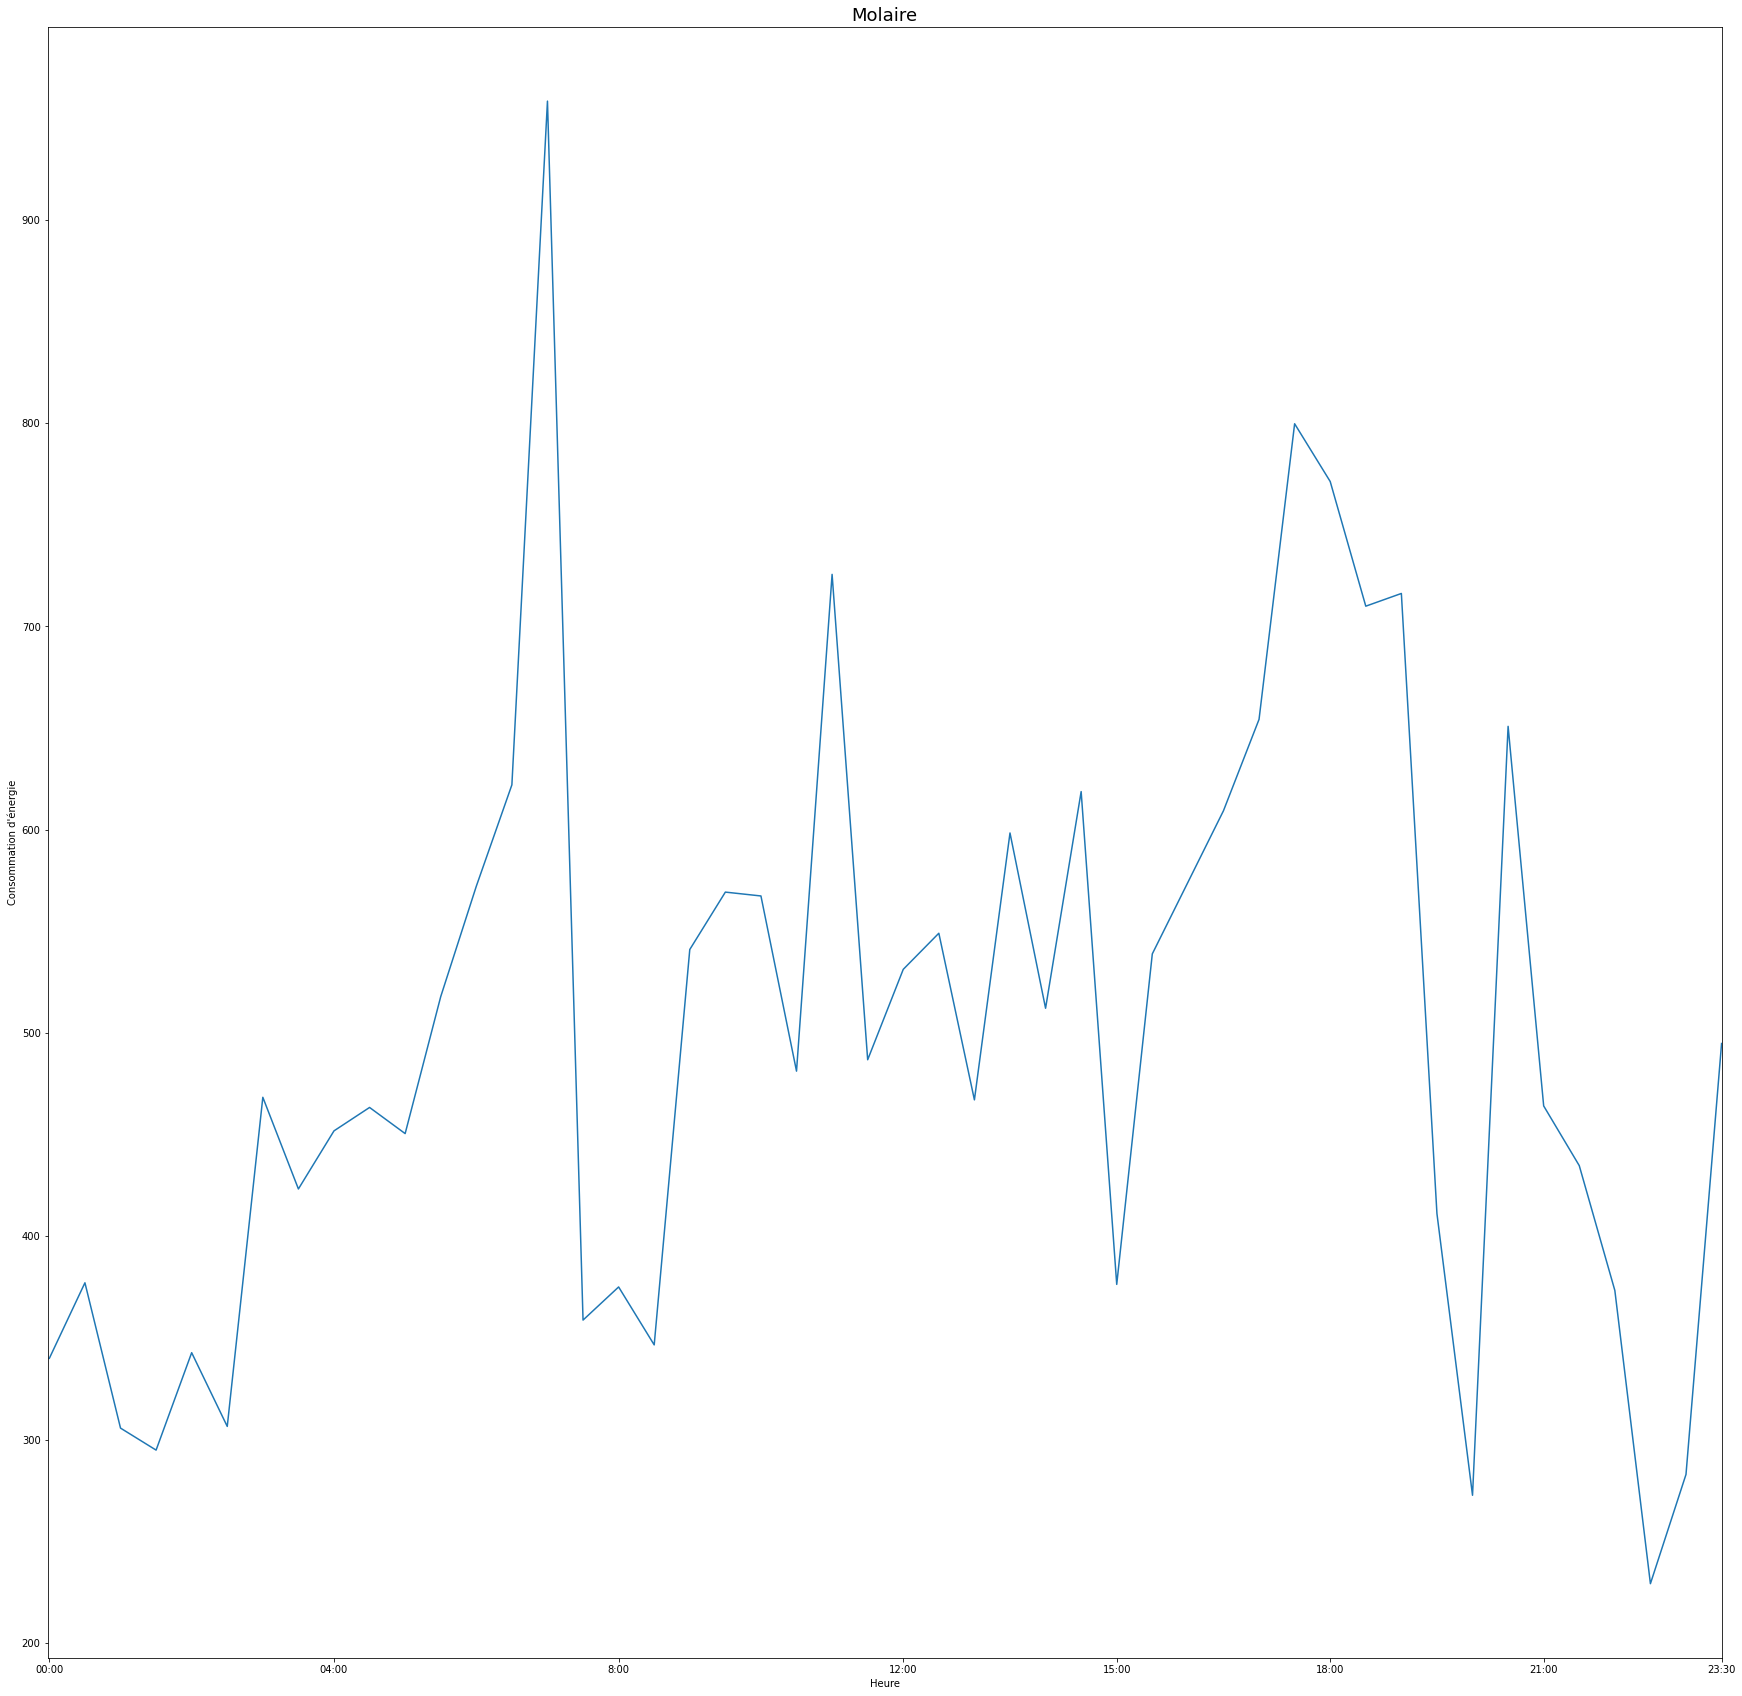

In [95]:
haute_conso_idf=haute_conso[haute_conso["region_x"]=="Île-de-France"]
haute_conso_30_09_2020 = haute_conso_idf[haute_conso_idf["date"]=="2020-09-30"]
haute_conso_30_09_2020["heure"]=haute_conso_30_09_2020["horodate"].apply(lambda x : x[11:16])
total_haute_conso_30_09_2020=haute_conso_30_09_2020.groupby("heure")["energie_soutiree_moyenne"].mean().reset_index()

plt.figure(figsize=(30, 30))
axes = plt.gca()
axes.set_xlim("00:00","00:00")
plt.plot(total_haute_conso_30_09_2020["heure"],total_haute_conso_30_09_2020["energie_soutiree_moyenne"] )
t2=["00:00","04:00","08:00","12:00","15:00","18:00","21:00","23:30"]
plt.xticks(t2,["00:00","04:00","8:00","12:00","15:00","18:00","21:00","23:30"])
plt.xlabel('Heure')

plt.ylabel("Consommation d'énergie")
plt.title('Molaire',size=18)
plt.show()


## Nombre d'usager haute conso / basse conso :

In [98]:
haute_conso.groupby("region_x")["nb_points_soutirage"].sum()

region_x
Auvergne-Rhône-Alpes          10342874882
Bourgogne-Franche-Comté        3090064793
Bretagne                       3821327663
Centre-Val de Loire            2813783745
Grand-Est                      3691778142
Hauts-de-France                3554586978
Normandie                      3137553111
Nouvelle Aquitaine             7552617884
Occitanie                      6819350198
Pays de la Loire               4175111991
Provence-Alpes-Côte d'Azur     5531272483
Île-de-France                 13182934273
Name: nb_points_soutirage, dtype: int64

In [99]:
basse_conso.groupby("region_x")["nb_points_soutirage"].sum()

region_x
Auvergne-Rhône-Alpes          41071174499
Bourgogne-Franche-Comté       13760896990
Bretagne                      15890056035
Centre-Val de Loire           10101276533
Grand-Est                     19650929534
Hauts-de-France               26277135031
Normandie                     14663933387
Nouvelle Aquitaine            24782773348
Occitanie                     28843690329
Pays de la Loire              17000013109
Provence-Alpes-Côte d'Azur    24789080665
Île-de-France                 73726483704
Name: nb_points_soutirage, dtype: int64